In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as  plt
import sklearn

In [2]:
df = pd.read_csv("german_credit_data.csv")

In [3]:
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


# dropping columns 

In [4]:
del df['Unnamed: 0']
df.head(3)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good


# taking care of NULL values 

In [5]:
df["Saving accounts"].fillna('None', inplace= True)
df["Checking account"].fillna('None', inplace= True)

In [6]:
df['Job']

0      2
1      2
2      1
3      2
4      2
      ..
995    1
996    3
997    2
998    2
999    2
Name: Job, Length: 1000, dtype: int64

### risk across job types

C:\Users\Jishan\anaconda3\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


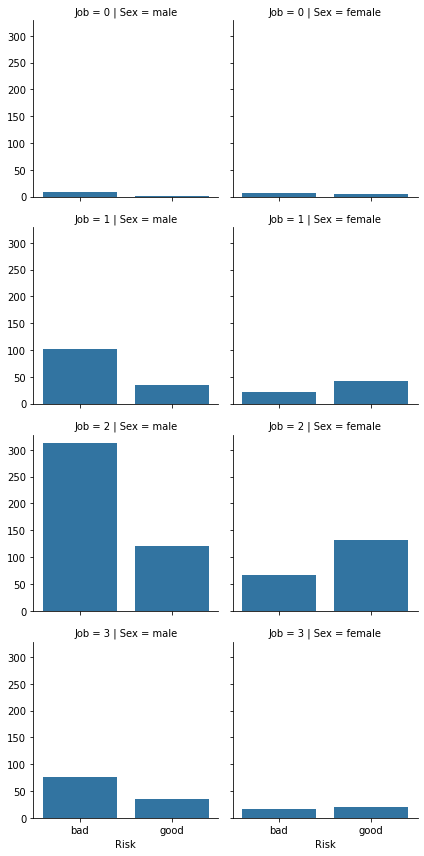

In [9]:
g = sns.FacetGrid(df, col="Sex", palette = "Set1", row="Job")
g = g.map(sns.countplot, "Risk")

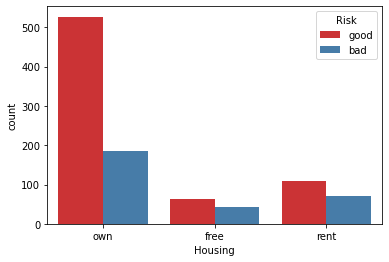

In [10]:
sns.countplot(x="Housing",palette = "Set1", hue="Risk", data=df)
plt.show()

<ipython-input-11-c329b8bc8573>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


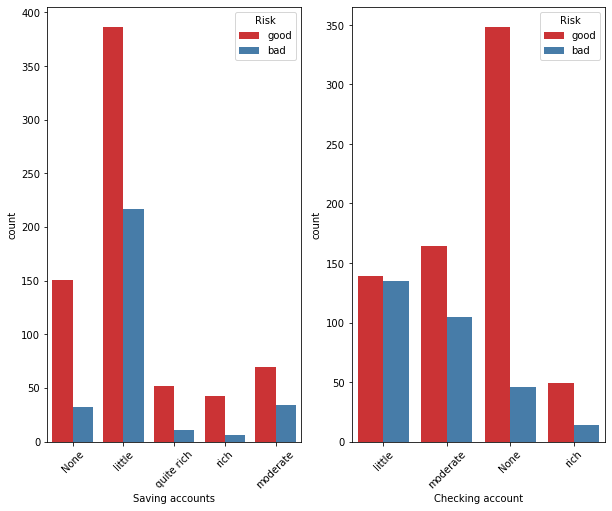

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,8))

sns.countplot(x="Saving accounts",palette = "Set1", hue="Risk", data=df, ax=ax1)

sns.countplot(x="Checking account",palette = "Set1", hue="Risk", data=df, ax=ax2)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


fig.show()

### credit distribution by loan duration and age 

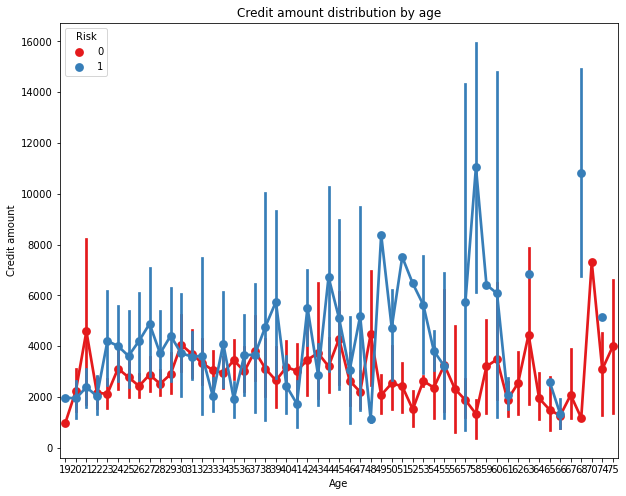

In [42]:
plt.figure(figsize=(10,8))


ax = sns.pointplot(x="Age", y="Credit amount", hue="Risk",
                   data=df, palette="Set1", figsize=(18,18))
plt.title("Credit amount distribution by age")
plt.show()


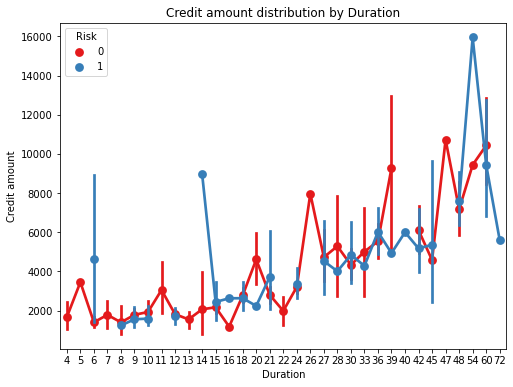

In [40]:
plt.figure(figsize=(8,6))
ax = sns.pointplot(x="Duration", y="Credit amount", hue="Risk",
                   data=df, palette="Set1", figsize=(18,18))
plt.title("Credit amount distribution by Duration")

plt.show()

### Feature engineering 

In [33]:
# getting dummies for all the categorical variables
dummies_columns = ['Job', 'Purpose', 'Sex', 'Housing', 'Saving accounts', 'Checking account']
for col in dummies_columns:
    df = df.merge(pd.get_dummies(df[col], drop_first=True, prefix=str(col)), left_index=True, right_index=True) 

# encoding risk as binary
r = {"good":0, "bad": 1}
df['Risk'] = df['Risk'].map(r)

# drop redundant variables
columns_to_drop = ['Job', 'Purpose','Sex','Housing','Saving accounts','Checking account']
df.drop(columns_to_drop, axis=1, inplace=True)

df.head()

,Age,Credit amount,Duration,Risk,Job_1,Job_2,Job_3,Purpose_car,Purpose_domestic appliances,Purpose_education,...,Sex_male,Housing_own,Housing_rent,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_little,Checking account_moderate,Checking account_rich
0,67,1169,6,0,0,1,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0
1,22,5951,48,1,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
2,49,2096,12,0,1,0,0,0,0,1,...,1,1,0,1,0,0,0,0,0,0
3,45,7882,42,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
4,53,4870,24,1,0,1,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0


In [34]:
df['Log_CA'] = np.log(df['Credit amount'])

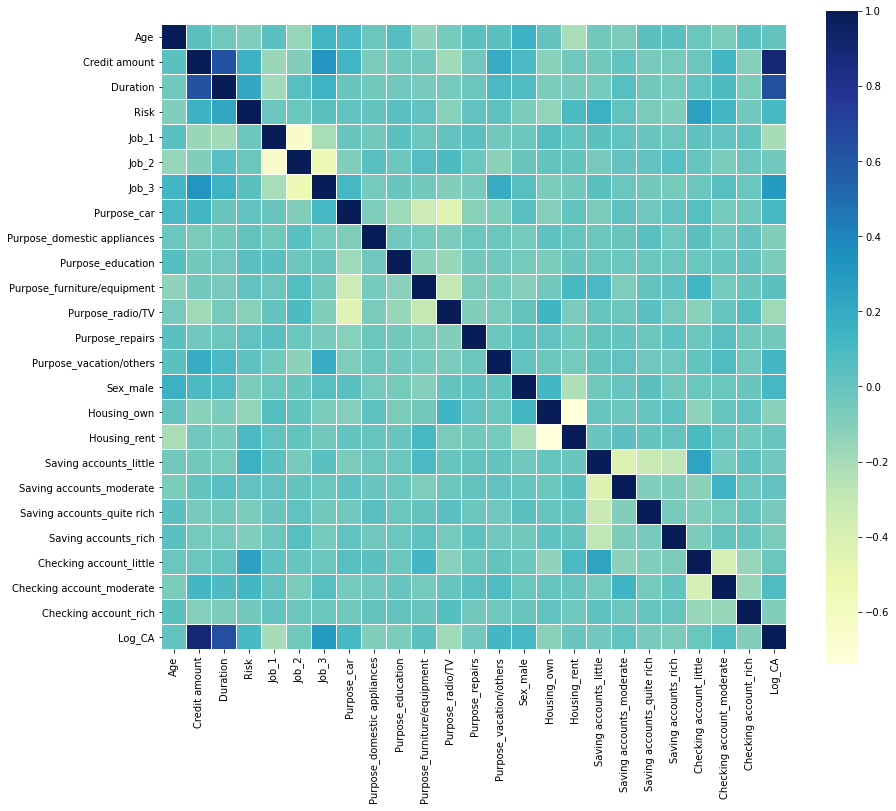

In [44]:
plt.figure(figsize=(14,12))
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', cmap='YlGnBu')
plt.show()

### model testing and selecting "recall"  as evaluation metric 

In [46]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
#from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

In [47]:
X = df.drop(['Risk', 'Credit amount'], axis=1).values
y = df['Risk'].values

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

In [48]:
log = LogisticRegression()
log.fit(X_train, y_train)
y_pred_log = log.predict(X_test)
print(accuracy_score(y_pred_log, y_test))
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

0.75
[[127  14]
 [ 36  23]]
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       141
           1       0.62      0.39      0.48        59

    accuracy                           0.75       200
   macro avg       0.70      0.65      0.66       200
weighted avg       0.73      0.75      0.73       200



C:\Users\Jishan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print(accuracy_score(y_pred_knn, y_test))
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

0.675
[[117  24]
 [ 41  18]]
              precision    recall  f1-score   support

           0       0.74      0.83      0.78       141
           1       0.43      0.31      0.36        59

    accuracy                           0.68       200
   macro avg       0.58      0.57      0.57       200
weighted avg       0.65      0.68      0.66       200



In [58]:
cm= confusion_matrix(y_test, y_pred_knn)
labels = ['Bad', 'Good']
print(classification_report(y_test, y_pred_knn, target_names=labels))

              precision    recall  f1-score   support

         Bad       0.74      0.83      0.78       141
        Good       0.43      0.31      0.36        59

    accuracy                           0.68       200
   macro avg       0.58      0.57      0.57       200
weighted avg       0.65      0.68      0.66       200



In [50]:
svc = SVC(kernel='linear', gamma=10, C=0.8)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
print(accuracy_score(y_pred_svc, y_test))
print(confusion_matrix(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))
    

0.76
[[129  12]
 [ 36  23]]
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       141
           1       0.66      0.39      0.49        59

    accuracy                           0.76       200
   macro avg       0.72      0.65      0.67       200
weighted avg       0.75      0.76      0.74       200



In [57]:
cm= confusion_matrix(y_test, y_pred_svc)
labels = ['Bad', 'Good']
print(classification_report(y_test, y_pred_svc, target_names=labels))

              precision    recall  f1-score   support

         Bad       0.78      0.91      0.84       141
        Good       0.66      0.39      0.49        59

    accuracy                           0.76       200
   macro avg       0.72      0.65      0.67       200
weighted avg       0.75      0.76      0.74       200



In [51]:
rf = RandomForestClassifier(max_depth=9, max_features=15, min_samples_leaf=5, n_estimators=25)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(accuracy_score(y_pred_rf, y_test))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

0.785
[[133   8]
 [ 35  24]]
              precision    recall  f1-score   support

           0       0.79      0.94      0.86       141
           1       0.75      0.41      0.53        59

    accuracy                           0.79       200
   macro avg       0.77      0.68      0.69       200
weighted avg       0.78      0.79      0.76       200



In [56]:
cm= confusion_matrix(y_test, y_pred_rf)
labels = ['Bad', 'Good']
print(classification_report(y_test, y_pred_rf, target_names=labels))

              precision    recall  f1-score   support

         Bad       0.79      0.94      0.86       141
        Good       0.75      0.41      0.53        59

    accuracy                           0.79       200
   macro avg       0.77      0.68      0.69       200
weighted avg       0.78      0.79      0.76       200



In [52]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print(accuracy_score(y_pred_nb, y_test))
print(confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

0.615
[[98 43]
 [34 25]]
              precision    recall  f1-score   support

           0       0.74      0.70      0.72       141
           1       0.37      0.42      0.39        59

    accuracy                           0.61       200
   macro avg       0.56      0.56      0.56       200
weighted avg       0.63      0.61      0.62       200



In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report #To evaluate our model


In [55]:
cm= confusion_matrix(y_test, y_pred_nb)
labels = ['Bad', 'Good']
print(classification_report(y_test, y_pred_nb, target_names=labels))

              precision    recall  f1-score   support

         Bad       0.74      0.70      0.72       141
        Good       0.37      0.42      0.39        59

    accuracy                           0.61       200
   macro avg       0.56      0.56      0.56       200
weighted avg       0.63      0.61      0.62       200



Text(0.5, 15.0, 'Predicted label')

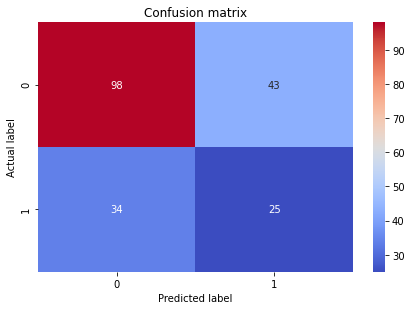

In [59]:
conf_matrix = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="coolwarm" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [72]:
from sklearn import model_selection

Models = {
    "SVC": SVC(),
    "LogRegression":   LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "KNN":  KNeighborsClassifier(n_neighbors = 1),

    "GaussianNaiveBayes": GaussianNB()
   
}

In [73]:
cv_results = pd.DataFrame(columns=['model', 'train_score', 'test_score'])
for key in Models.keys():
    cv_res = model_selection.cross_validate(Models[key], X_train, y_train, 
                                             return_train_score=True,
                                             scoring="f1",
                                             cv=5, n_jobs=-1)
    res = {
        'model': key, 
        'train_score': cv_res["train_score"].mean(), 
        'test_score': cv_res["test_score"].mean(),
        'fit_time': cv_res["fit_time"].mean(),
        'score_time': cv_res["score_time"].mean()
        }
    cv_results = cv_results.append(res, ignore_index=True)
    print("CV for model:", key, "done.")
cv_results.style.background_gradient(cmap='Blues')

CV for model: SVC done.
CV for model: LogRegression done.
CV for model: RandomForest done.
CV for model: KNN done.
CV for model: GaussianNaiveBayes done.


,model,train_score,test_score,fit_time,score_time
0,SVC,0.000000,0.000000,0.016357,0.008376
1,LogRegression,0.498718,0.460989,0.021157,0.001000
2,RandomForest,1.000000,0.432251,0.137616,0.010970
3,KNN,1.000000,0.382001,0.000599,0.007181
4,GaussianNaiveBayes,0.531087,0.520952,0.000997,0.000997


In [74]:
#GaussianNaiveBayes has lowest runtime
#RandomForest has the best train and test score. 

#### Considering all RandomForest is the best fitting model